# **Step 1:** Training a <nobr>Micro$\mathbb{S}$plit</nobr> Model

# Introduction - what does this notebook do?

<div class="alert alert-block alert-info">
<b>Note:</b> Despite network training arguably being the most important step, the execution of this notebook is optional. If you do not run this notebook, in Step 2 (prediction) we offer you to use pretrained model checkpoints. Like in any respected cooking show: "we have already prepared someting before the show"... 😉
</div>

Below, we will train a <nobr>Micro$\mathbb{S}$plit</nobr> network for unmixing two superimposed channels from our HT-LIF24 dataset. 

This dataset contains four labeled structures, and soon you will be asked to choose which of these two you want to learn to unmix: 
1. Cell Nucleui,
1. Microtubules,
1. Nuclear Membrane, and
1. Centromeres/Kinetocores.

Additionally to four total structures, this dataset also offers acquisitions taken with different exposure times, hence, the data is available at various SNR, i.e. [signal-to-noise ratios](https://en.wikipedia.org/wiki/Signal-to-noise_ratio#:~:text=Signal%2Dto%2Dnoise%20ratio%20(,power%2C%20often%20expressed%20in%20decibels.). Shorter exposure times lead to a collection of fewer photos, which leads to more noise and therefore a lower SNR.

The lower the SNR of the data you will choose to train <nobr>Micro$\mathbb{S}$plit</nobr> with, the more important will the unsupervised denoising feature of <nobr>Micro$\mathbb{S}$plit</nobr> become.

But enough introduction, let's begin!

## Background: what is <nobr>Micro$\mathbb{S}$plit</nobr> training all about?
Training is done in a supervised way. For every input patch, we have the two corresponding target patches using which we train our MicroSplit. 
Besides the primary input patch, we also feed LC inputs to MicroSplit. We introduced LC inputs in [μSplit: efficient image decomposition for microscopy data](https://openaccess.thecvf.com/content/ICCV2023/papers/Ashesh_uSplit_Image_Decomposition_for_Fluorescence_Microscopy_ICCV_2023_paper.pdf), which enabled the network to understand the global spatial context around the input patch.

To enable unsupervised denoising, we integrated the KL loss formulation and Noise models from our previous work [denoiSplit: a method for joint microscopy image splitting and unsupervised denoising](https://eccv.ecva.net/virtual/2024/poster/2538). 

The loss function for MicroSplit is a weighted average of denoiSplit loss and μSplit loss. For both denoiSplit and μSplit, their loss expression have two terms: KL divergence loss and likelihood loss. For more details, please refer to the respective papers.

# Let's do it, let's train a <nobr>Micro$\mathbb{S}$plit</nobr> Model!

**You are new to Jupyter notebooks?** Don't worry, if you take the time to read all our explanations, we will guide you through them and you will understand a lot. Still, you will likely end up less frustrated, if you do not even start with the ambition to interpret the purpose of every line of code.
Let's start with a nice example, the imports to enable the remainder of this notebook. Ignore it (unless you know what you are doing) and just click **⇧*Shift* + ⏎*Enter*** to execute this (and all other) code cells. 

In [1]:
# importing all the things we need further down

import pooch
from pathlib import Path
from pytorch_lightning import Trainer
from torch.utils.data import DataLoader
from careamics.lightning import VAEModule

from microsplit_reproducibility.configs.factory import (
    create_algorithm_config,
    get_likelihood_config,
    get_loss_config,
    get_model_config,
    get_optimizer_config,
    get_training_config,
    get_lr_scheduler_config,
)
from microsplit_reproducibility.utils.callbacks import get_callbacks
from microsplit_reproducibility.utils.io import load_checkpoint, load_checkpoint_path
from microsplit_reproducibility.datasets import create_train_val_datasets
from microsplit_reproducibility.utils.utils import (
    plot_training_metrics,
    plot_input_patches,
    plot_training_outputs,
)

# Dataset specific imports...
from microsplit_reproducibility.configs.parameters.HT_H23B import get_microsplit_parameters
from microsplit_reproducibility.configs.data.HT_H23B import get_data_configs
from microsplit_reproducibility.datasets.HT_H23B import get_train_val_data

# **Step 1.1:** Data Preparation

The next line is likely a bit confusing at first.

Since the channel unmixing capabilities of <nobr>Micro$\mathbb{S}$plit</nobr> are trained in a supervised way, we must later feed *(i)* input images that contain both structures, and *(ii)* two separate channels that show these two structures sepaerately.

Above, we made you choose the two seperated structures, but we now must also sum up those images into the superimposed input images. We could do so 'on-the-fly', but that would take a while. Hence, we have already done so for all combinations of structures you can find in this dataset and ***the next cell simply figures out where the appropriately prepared data can be found***.

### Download the data
Depending on your internet connection, this will take a while...

Note that appropriate noise models will only be downloaded if they were not created by executing the notebook `00_noisemodels.ipynb`.

In [6]:
DATA = pooch.create(
    path=f"./data/",
    base_url=f"https://download.fht.org/jug/msplit/ht_h23b/data/",
    registry={f"ht_h23b.zip": None},
)

NOISE_MODELS = pooch.create(
    path=f"./noise_models/",
    base_url=f"https://download.fht.org/jug/msplit/ht_h23b.zip/noise_models/",
    registry={
        f"ht_h23b_nm_raw_data.npz": None,
        f"ht_h23b_nm_raw_data.npz": None,
    },
)

Note that the following notebook will download all you need. In case you see no messages announcing any downloads, you already have this data in the notebook folder.

In [7]:
for fname in NOISE_MODELS.registry:
    NOISE_MODELS.fetch(fname, progressbar=True)
print('---------')
for fname in DATA.registry:
    DATA.fetch(fname, processor=pooch.Unzip(), progressbar=True)

---------


### Next, we load the image data to be processed

Note that depending on the amount of GPU memory you have available, you might want to adjust the batch size. The default is 32, but you can reduce it to 16 if you run out of memory by changing the <i> batch_size </i> parameter in <i> get_microsplit_parameters </i> below.


In [9]:
# setting up train, validation, and test data configs
train_data_config, val_data_config, test_data_config = get_data_configs(
    dset_type=EXPOSURE_DURATION, channel_idx_list=CHANNEL_IDX_LIST,
)
# setting up MicroSplit parametrization
experiment_params = get_microsplit_parameters(
    dset_type=EXPOSURE_DURATION, nm_path=NOISE_MODELS.path, channel_idx_list=CHANNEL_IDX_LIST, batch_size=32
)

# start the download of required files
train_dset, val_dset, _, data_stats = create_train_val_datasets(
    datapath=DATA.path / f"ht_lif24_{EXPOSURE_DURATION}.zip.unzip/{EXPOSURE_DURATION}",
    train_config=train_data_config,
    val_config=val_data_config,
    test_config=val_data_config,
    load_data_func=get_train_val_data,
)

Loading from data/ht_lif24_5ms.zip.unzip/5ms/Set1/uSplit_5ms.nd2
ND2 dimensions: {'P': 20, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from data/ht_lif24_5ms.zip.unzip/5ms/Set2/uSplit_5ms.nd2
ND2 dimensions: {'P': 11, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from data/ht_lif24_5ms.zip.unzip/5ms/Set3/uSplit_5ms.nd2
ND2 dimensions: {'P': 20, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from data/ht_lif24_5ms.zip.unzip/5ms/Set4/uSplit_5ms.nd2
ND2 dimensions: {'P': 20, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from data/ht_lif24_5ms.zip.unzip/5ms/Set5/uSplit_5ms.nd2
ND2 dimensions: {'P': 21, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from data/ht_lif24_5ms.zip.unzip/5ms/Set6/uSplit_5ms.nd2
ND2 dimensions: {'P': 20, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: Fals

***Optional:*** inspect data configurations and <nobr>Micro$\mathbb{S}$plit</nobr> config

In [10]:
do_show_configs = False

if do_show_configs:
    print('FYI: train_data_config')
    print('----------------------')
    for cfg in train_data_config:
        print(cfg)

    print('\nFYI: experiment_params')
    print('----------------------')
    print(experiment_params)
else:
    print('You opted out of having all params printed... swiftly moving on... ;)')

You opted out of having all params printed... swiftly moving on... ;)


### Wanna trade speed for model quality? (1/2)
<div class="alert alert-block alert-info">
<b>Note:</b> If you just want to get an idea of the process of training <nobr>Micro$\mathbb{S}$plit</nobr> and you do not intend to get best-possible results, feel invited to crop down on the training data to be used further down. <i><b>Do not do this</b> if you intend to train a competitive model!!!</i>
</div>

In [11]:
# If True, training and validation data will be reduced to only 
# consisting of 2 and 1 frames, respectively.
reduce_data = True

if reduce_data:
    print("Using REDUCED training and validation data for quick'n'dirty testing!")
    train_dset.reduce_data([0,1])
    val_dset.reduce_data([0])
else:
    print('Using the full set of training and validation data!')
print(f'(This are {train_dset.get_num_frames()} and {val_dset.get_num_frames()} frames, respectively.)') 

Using REDUCED training and validation data for quick'n'dirty testing!
[LCMultiChDloader] Data reduced. New data shape: (2, 1608, 1608, 3)
[LCMultiChDloader] Data reduced. New data shape: (1, 1608, 1608, 3)
(This are 2 and 1 frames, respectively.)


### Final step: create Dataloaders for network training

In [12]:
train_dloader = DataLoader(
    train_dset,
    batch_size=experiment_params["batch_size"],
    num_workers=experiment_params["num_workers"],
    shuffle=True,
)
val_dloader = DataLoader(
    val_dset,
    batch_size=experiment_params["batch_size"],
    num_workers=experiment_params["num_workers"],
    shuffle=False,
)

# **Step 1.2:** Prepare <nobr>Micro$\mathbb{S}$plit</nobr> Training
Next, we create all the configs for the upcoming network training run. These lines are not very intuitive and if you don't intend to dive really deep into CAREamics and the internals of <nobr>Micro$\mathbb{S}$plit</nobr>, you might just execute these cells and move on.

In [13]:
# making our data_stas known to the experiment we prepare
experiment_params["data_stats"] = data_stats

# setting up training losses and model config (using default parameters)
loss_config = get_loss_config(**experiment_params)
model_config = get_model_config(**experiment_params)
gaussian_lik_config, noise_model_config, nm_lik_config = get_likelihood_config(
    **experiment_params
)
training_config = get_training_config(**experiment_params)

# setting up learning rate scheduler and optimizer (using default parameters)
lr_scheduler_config = get_lr_scheduler_config(**experiment_params)
optimizer_config = get_optimizer_config(**experiment_params)

# finally, assemble the full set of experiment configurations...
experiment_config = create_algorithm_config(
    algorithm=experiment_params["algorithm"],
    loss_config=loss_config,
    model_config=model_config,
    gaussian_lik_config=gaussian_lik_config,
    nm_config=noise_model_config,
    nm_lik_config=nm_lik_config,
    lr_scheduler_config=lr_scheduler_config,
    optimizer_config=optimizer_config,
)

/localscratch/mamba/envs/microsplit/lib/python3.9/site-packages/careamics/utils/serializers.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(lst)


### Wanna trade speed for model quality? (2/2)
<div class="alert alert-block alert-info">
<b>Note:</b> Similar to above, if you simply want to go over this notebook quickly and you don't care about training a competitive model, set <i>`reduce_training_epochs=True`</i> in the cell below. 

Note that if <i> reduce_training_epochs </i> is set to <i>False </i>, the default number of epochs is 400. However, early stopping will be invoked when the loss is no longer decreasing, so the actual number of epochs trained will most likely be less than 400.
</div>

In [17]:
reduce_training_epochs = True

# if True, train for only 10 epochs (quick'n'dirty testing mode)
if reduce_training_epochs:
    training_config.num_epochs = 10

print(f'Will train for {training_config.num_epochs} epochs!')

Will train for 1 epochs!


## Initialize the <nobr>Micro$\mathbb{S}$plit</nobr> model to be trained..

In [18]:
model = VAEModule(algorithm_config=experiment_config)

[GaussianMixtureNoiseModel] min_sigma: 0.125
[GaussianMixtureNoiseModel] min_sigma: 0.125
[MultiChannelNoiseModel] Nmodels count:2
[GaussianLikelihood] PredLVar:pixelwise LowBLVar:-5.0


### *Load checkpoint (optional and for you to implement)*

<div class="alert alert-block alert-success">
<b>Note:</b> If you would like to continue a previous training run or finetune a compatible pre-trained model, here would be a good place. You will need to figure out how to implement this for your use-case, but to give you a head-start, we left three potentially useful lines of code below.
</div>

In [15]:
# from microsplit_reproducibility.notebook_utils.HT_LIF24 import load_pretrained_model
# ckpt_path = load_checkpoint_path(f"./pretrained_checkpoints/{EXPOSURE_DURATION}/", best=True)
# load_pretrained_model(model, ckpt_path)

## Show some training data for a final check!
***Tip:*** we show you a few samples of the prepared training data. In case you don't like what you see, execute the cell again and other randomly chosen patches will be shown!

[1776, 4199, 2622]

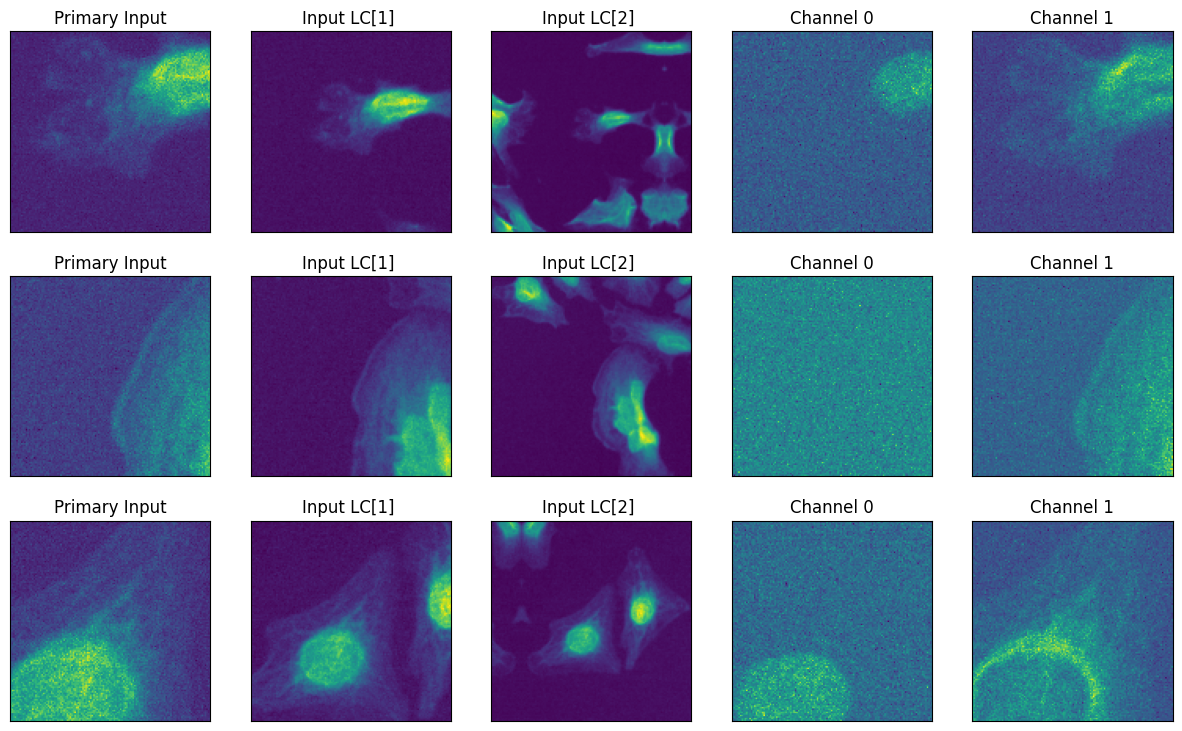

In [19]:
plot_input_patches(dataset=train_dset, num_channels=2, num_samples=3, patch_size=128)

# **Step 1.3:** Train the prepared model!
***Note:*** if this takes too long, there were to places above where we gave you options to *(i)* reduce the amount of training data, and *(ii)* chose to train for fewer epochs. Revisit your choices if you want to!

***Note:*** Depending on the amount of GPU memory you have available, you might want to adjust the batch size. The default is 32, but you can reduce it to 16 if you run out of memory by changing the <i> batch_size </i> parameter in <i> get_microsplit_parameters </i> above.


In [ ]:
# create a CAREamics 'Trainer'
trainer = Trainer(
    max_epochs=training_config.num_epochs,
    # NOTE: if you are on a mac swap the accelerator to "mps"
    # accelerator=“mps”,
    accelerator="gpu",
    enable_progress_bar=True,
    callbacks=get_callbacks(f"./checkpoints/{EXPOSURE_DURATION}/"),
    precision=training_config.precision,
    gradient_clip_val=training_config.gradient_clip_val,
    gradient_clip_algorithm=training_config.gradient_clip_algorithm,
)
# start the training - yay!
trainer.fit(
    model=model,
    train_dataloaders=train_dloader,
    val_dataloaders=val_dloader,
)

## Show training loss curves...
Below, we plot for each epoch of your training run the *(i)* training reconstruction loss, *(ii)* training KL divergence loss, *(iii)* validation reconstruction loss, and *(iv)* validation PSNR. 

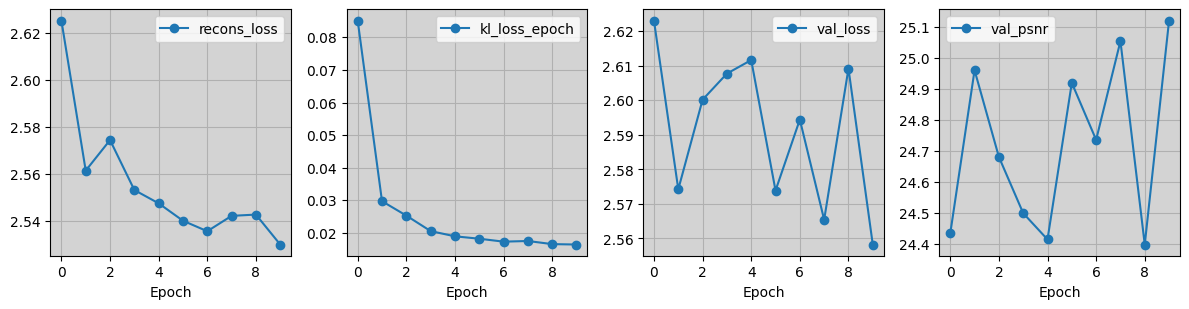

In [25]:
from pandas import read_csv
from microsplit_reproducibility.notebook_utils.HT_LIF24 import find_recent_metrics, plot_metrics
df = read_csv(find_recent_metrics())
plot_metrics(df)

# **Step 1.4:** Predict and visualize results for validation data...

In [26]:
from microsplit_reproducibility.notebook_utils.HT_LIF24 import get_unnormalized_predictions, get_target, get_input
stitched_predictions, _, _ = get_unnormalized_predictions(model, val_dset, EXPOSURE_DURATION, TARGET_CHANNEL_IDX_LIST, 
                                                    mmse_count = experiment_params['mmse_count'], num_workers=4, batch_size=8)
tar = get_target(val_dset)
inp = get_input(val_dset)

Predicting tiles: 100%|██████████████████████████████████████████████████████████████| 313/313 [08:59<00:00,  1.72s/it]


## Overview: visualize predictions on validation data...

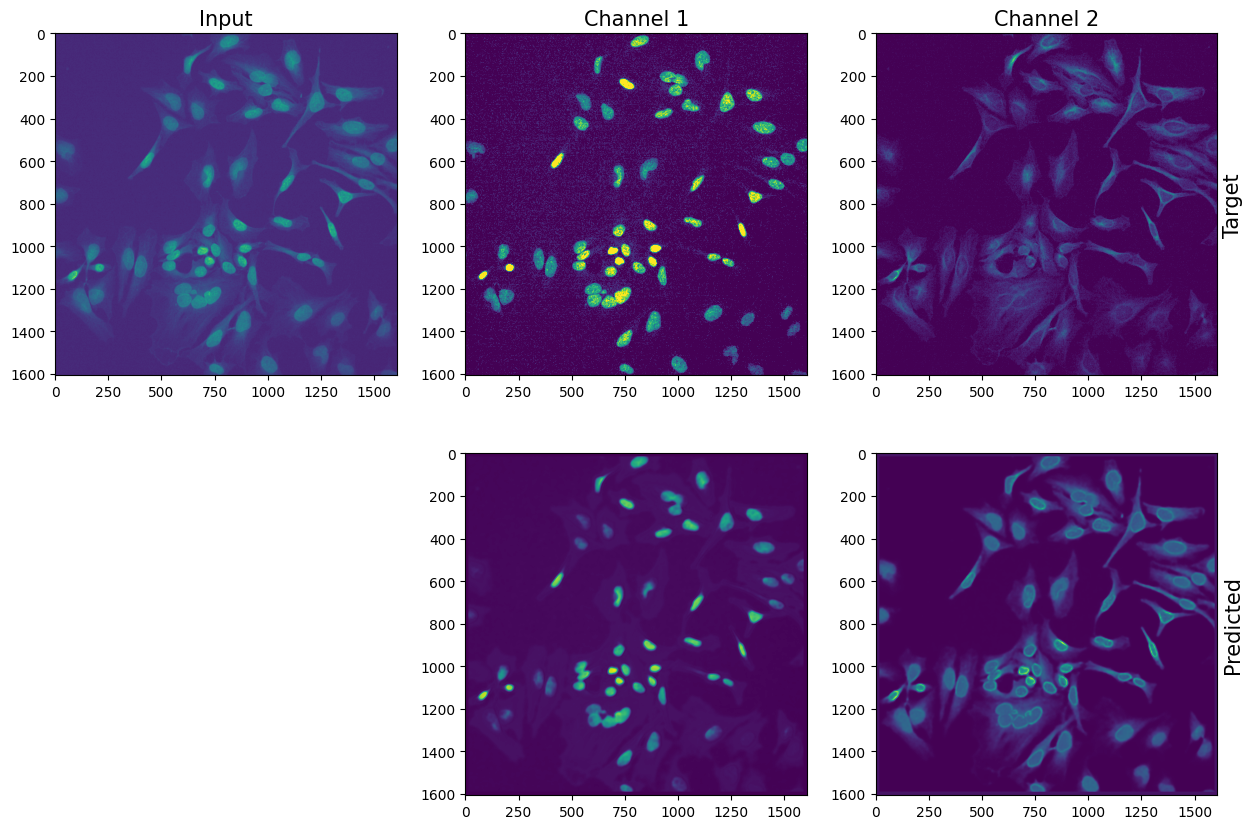

In [27]:
from microsplit_reproducibility.notebook_utils.HT_LIF24 import full_frame_evaluation
frame_idx = 0
assert frame_idx < len(stitched_predictions), f"Frame index {frame_idx} out of bounds"
full_frame_evaluation(stitched_predictions[frame_idx], tar[frame_idx], inp[frame_idx])

## Detailed view on some (foreground) locations...
Below, we show few random foreground locations and the corresponding <nobr>Micro$\mathbb{S}$plit</nobr> predictions.

As before, also here you can execute the cell multiple times and different randomly chosen locations will be plotted.

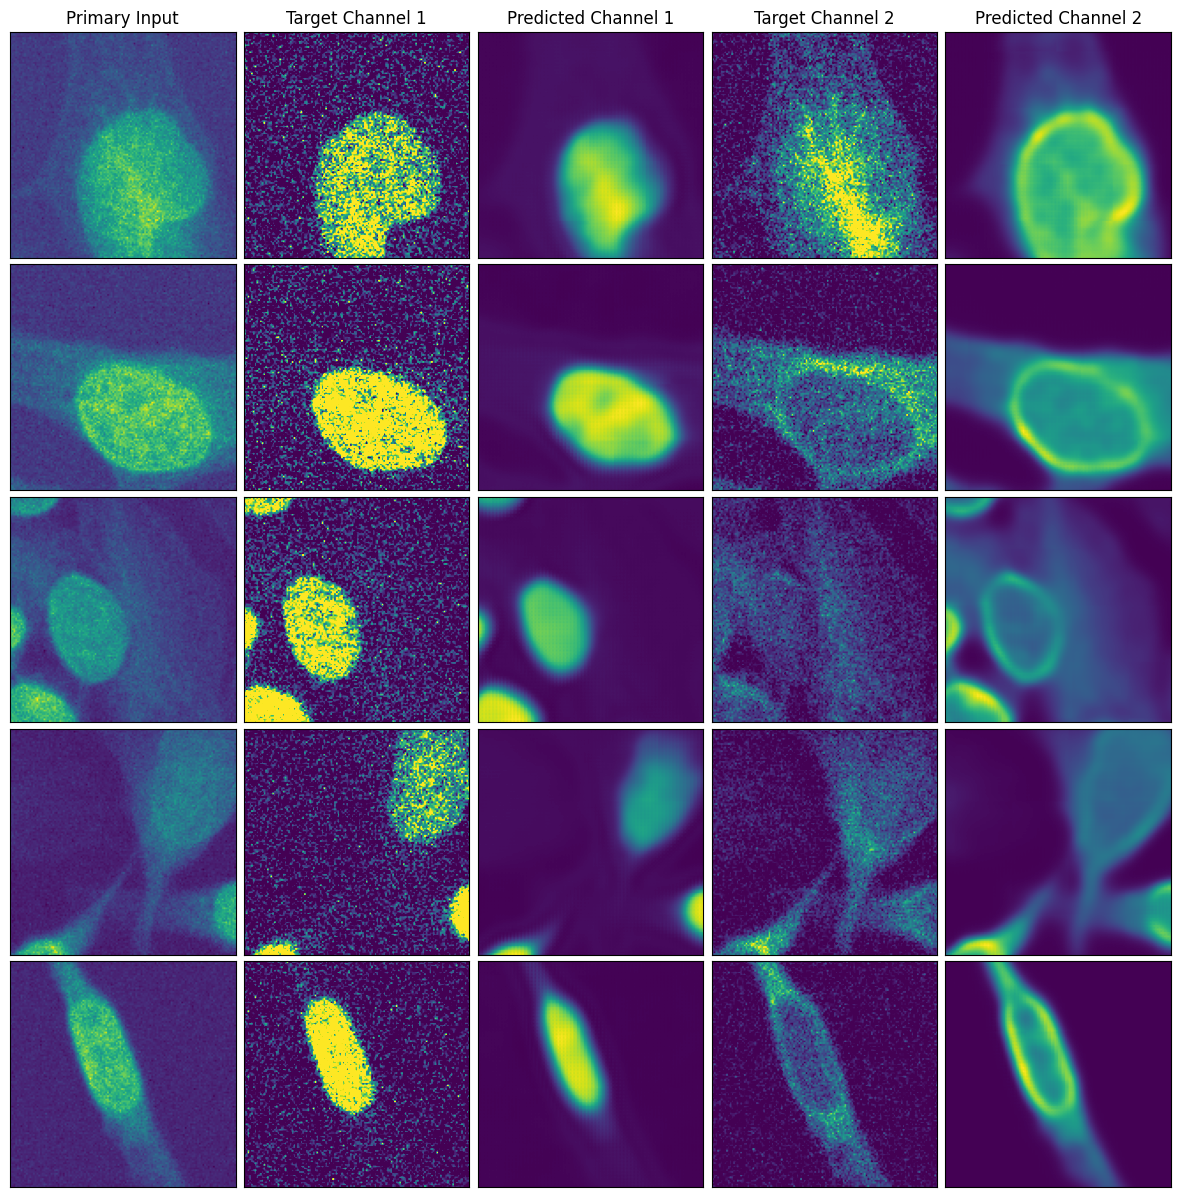

In [28]:
import numpy as np
from microsplit_reproducibility.utils.utils import clean_ax
from microsplit_reproducibility.notebook_utils.HT_LIF24 import pick_random_patches_with_content
import matplotlib.pyplot as plt

img_sz = 128
rand_locations = pick_random_patches_with_content(tar, 128)
h_start = rand_locations[2,0] #np.random.randint(stitched_predictions.shape[1] - img_sz)
w_start = rand_locations[2,1] #np.random.randint(stitched_predictions.shape[2] - img_sz)

ncols = 2*len(TARGET_CHANNEL_IDX_LIST) + 1
nrows = min(len(rand_locations), 5)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 3, nrows * 3))

for i, (h_start, w_start) in enumerate(rand_locations[:nrows]):
    ax[i,0].imshow(inp[0,h_start:h_start+img_sz, w_start:w_start+img_sz])
    for j in range(ncols//2):
        vmin = stitched_predictions[0,h_start:h_start+img_sz, w_start:w_start+img_sz,j].min()
        vmax = stitched_predictions[0,h_start:h_start+img_sz, w_start:w_start+img_sz,j].max()
        ax[i,2*j+1].imshow(tar[0,h_start:h_start+img_sz, w_start:w_start+img_sz,j], vmin=vmin, vmax=vmax)
        ax[i,2*j+2].imshow(stitched_predictions[0,h_start:h_start+img_sz, w_start:w_start+img_sz,j], vmin=vmin, vmax=vmax)

ax[0,0].set_title('Primary Input')
for i in range(len(TARGET_CHANNEL_IDX_LIST)):
    ax[0,2*i+1].set_title(f'Target Channel {i+1}')
    ax[0,2*i+2].set_title(f'Predicted Channel {i+1}')

# reduce the spacing between the subplots
plt.subplots_adjust(wspace=0.03, hspace=0.03)
clean_ax(ax)

## *Optional:* manual inspection of the predictions
<div class="alert alert-block alert-info">
<b> Task:</b> Set <i>y_start</i>, <i>x_start</i>, and <i>crop_size</i> to inspect the predictions at a  location of your choice.
</div>

Here the crop you selected:


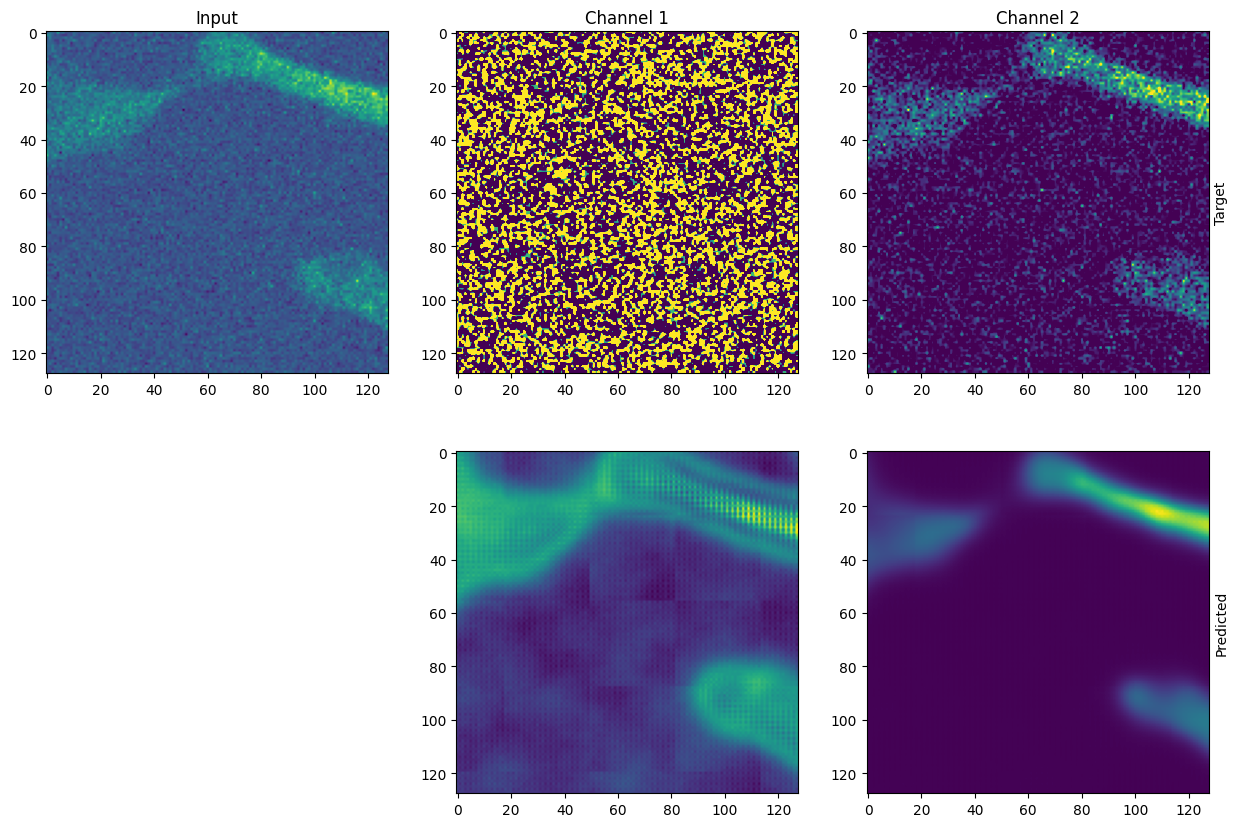

In [29]:
import numpy as np
y_start = 600  #np.random.randint(stitched_predictions.shape[1] - crop_size)
x_start = 1150 #np.random.randint(stitched_predictions.shape[2] - crop_size)
crop_size = 128

ncols = len(TARGET_CHANNEL_IDX_LIST) + 1
nrows = 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 5, nrows * 5))
ax[0,0].imshow(inp[0,y_start:y_start+crop_size, x_start:x_start+crop_size])
for i in range(ncols -1):
    vmin = stitched_predictions[0,y_start:y_start+crop_size, x_start:x_start+crop_size,i].min()
    vmax = stitched_predictions[0,y_start:y_start+crop_size, x_start:x_start+crop_size,i].max()
    ax[0,i+1].imshow(tar[0,y_start:y_start+crop_size, x_start:x_start+crop_size,i], vmin=vmin, vmax=vmax)
    ax[1,i+1].imshow(stitched_predictions[0,y_start:y_start+crop_size, x_start:x_start+crop_size,i], vmin=vmin, vmax=vmax)

# disable the axis for ax[1,0]
ax[1,0].axis('off')
ax[0,0].set_title("Input")
ax[0,1].set_title("Channel 1")
ax[0,2].set_title("Channel 2")
# set y labels on the right for ax[0,2]
ax[0,2].yaxis.set_label_position("right")
ax[0,2].set_ylabel("Target")

ax[1,2].yaxis.set_label_position("right")
ax[1,2].set_ylabel("Predicted")

print('Here the crop you selected:')

# ***Optional Step 1.4:*** Posterior Sampling
For a given input patch, <nobr>Micro$\mathbb{S}$plit</nobr> can generate multiple outputs. This is possible because <nobr>Micro$\mathbb{S}$plit</nobr> is learning a full posterior of possible solutions, which is a quite powerful feature!

As we elaborate in the <nobr>Micro$\mathbb{S}$plit</nobr> paper and also later in the calibration notebook `03_calibration.ipynb`, this allows users to visually judge and even quantify the (data) uncertainty in the predictions their trained model makes.

Below, we show two posterior samples and how much they differ for a few random foreground locations. Re-run the cell to see different randomly choosen locations and corresponding posterior samples.

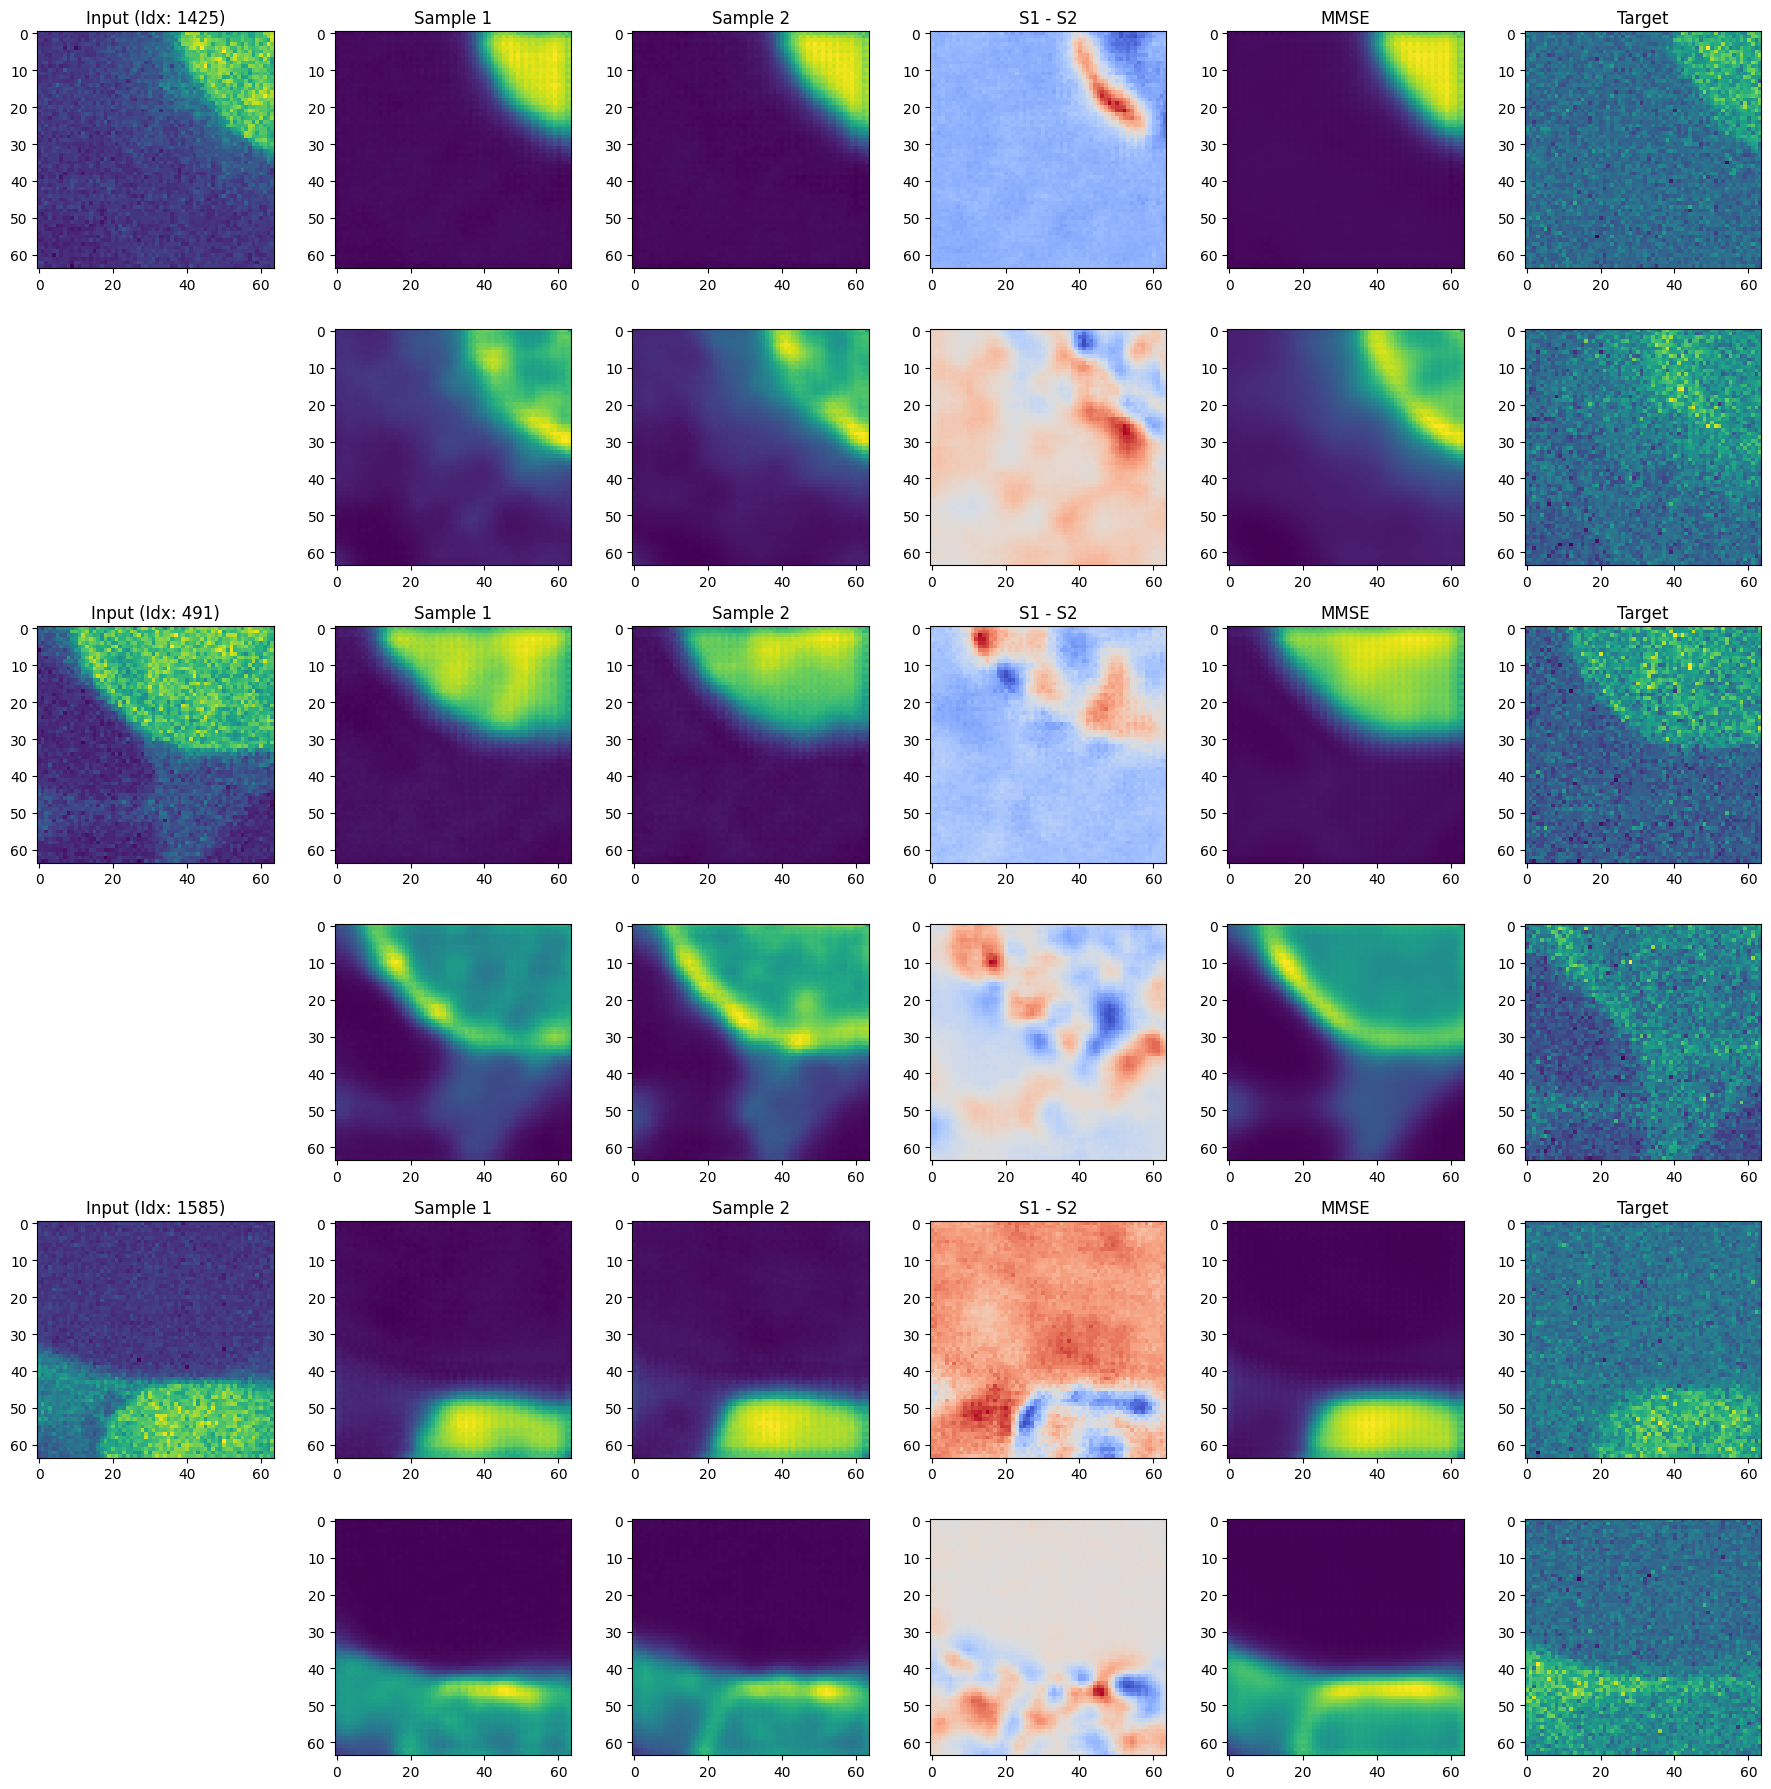

In [30]:
from microsplit_reproducibility.notebook_utils.HT_LIF24 import show_sampling
imgsz = 3
ncols = 6
examplecount = 3
_,ax = plt.subplots(figsize=(imgsz*ncols, imgsz*2*examplecount), ncols=ncols, nrows=2*examplecount)

show_sampling(val_dset, model, ax=ax[:2])
show_sampling(val_dset, model, ax=ax[2:4])
show_sampling(val_dset, model, ax=ax[4:6])
plt.tight_layout()

### You are done here! 👍 Congratulations! 🎉